# Bayesian Dynamic TWFE

In [1]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df = df.dropna(subset=['population'])
df.loc[df['treatment_group'] == 0, 'time_since_treatment'] = np.nan # コントロール群の処置後経過年数は欠損値
df['time_since_treatment'] = np.nan_to_num(df['time_since_treatment'], nan=1000)


In [4]:
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()

df.bridge_year = df.bridge_year.astype(str)
df.bridge_year = df.bridge_year.map(str.strip)
bridge_years, mn_bridge_years = df.bridge_year.factorize()

df['time_since_treatment'] = df['time_since_treatment'].astype(str)
df['time_since_treatment'] = df['time_since_treatment'].map(str.strip)
time_since_treatment, mn_time_since_treatments = df['time_since_treatment'].factorize()


## Dynamic TWFE

$$
\begin{aligned}
Y_{it} = \alpha_i + \lambda_t + \beta_l \cdot T_{i}  + \epsilon_{it} \\
\end{aligned}
$$

- $\beta_l$: 介入前後の経過時間

## 階層ベイズモデル 不均一分散

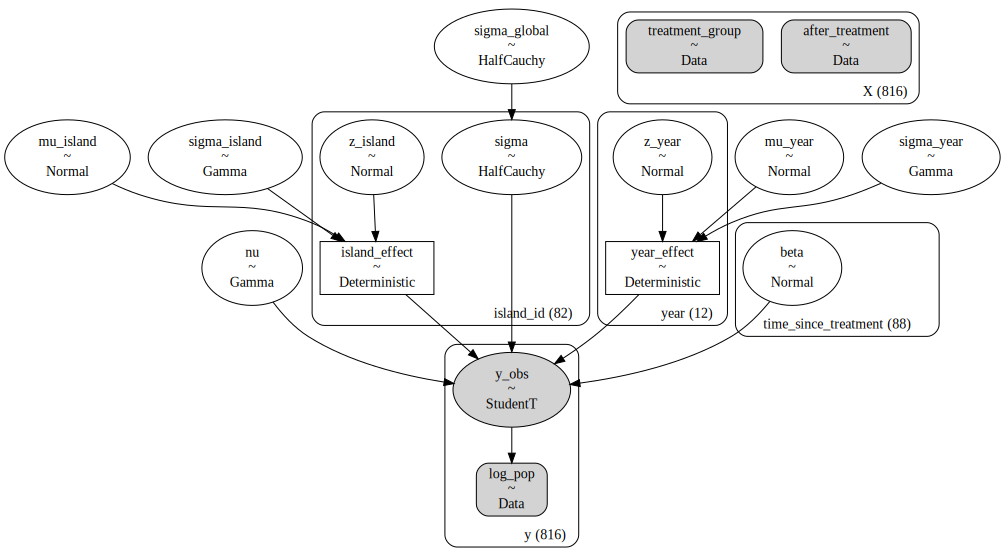

In [277]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[-46.0]', 'C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'time_since_treatment': time_since_treatment_dummies.columns,
}

with pm.Model(coords=COORDS) as model_hetero:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect

    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    sigma_global = pm.HalfCauchy('sigma_global', 1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_global, dims='island_id')

    # fixed effect
    # alpha = pm.Normal('alpha', qmu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='time_since_treatment')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(time_since_treatment_dummies, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_id], observed=log_pop, dims='y')

pm.model_to_graphviz(model_hetero)

In [278]:
with model_hetero:
    trace_hetero = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
        target_accept=.99
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [279]:
az.summary(trace_hetero, var_names=['sigma_global', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year', 'nu'], hdi_prob=0.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma_global   0.165   0.020     0.129      0.207      0.001    0.001   
mu_island      6.418   0.142     6.099      6.674      0.044    0.032   
sigma_island   1.981   0.156     1.609      2.356      0.063    0.047   
mu_year       -0.490   0.172    -0.889     -0.165      0.052    0.038   
sigma_year     0.627   0.125     0.387      0.861      0.013    0.009   
nu            27.495  14.187     8.756     57.363      2.064    1.469   

              ess_bulk  ess_tail  r_hat  
sigma_global     299.0     561.0   1.11  
mu_island         11.0      93.0   1.36  
sigma_island       6.0      15.0   1.76  
mu_year           11.0      28.0   1.30  
sigma_year        81.0     170.0   1.50  
nu                46.0     397.0   1.15

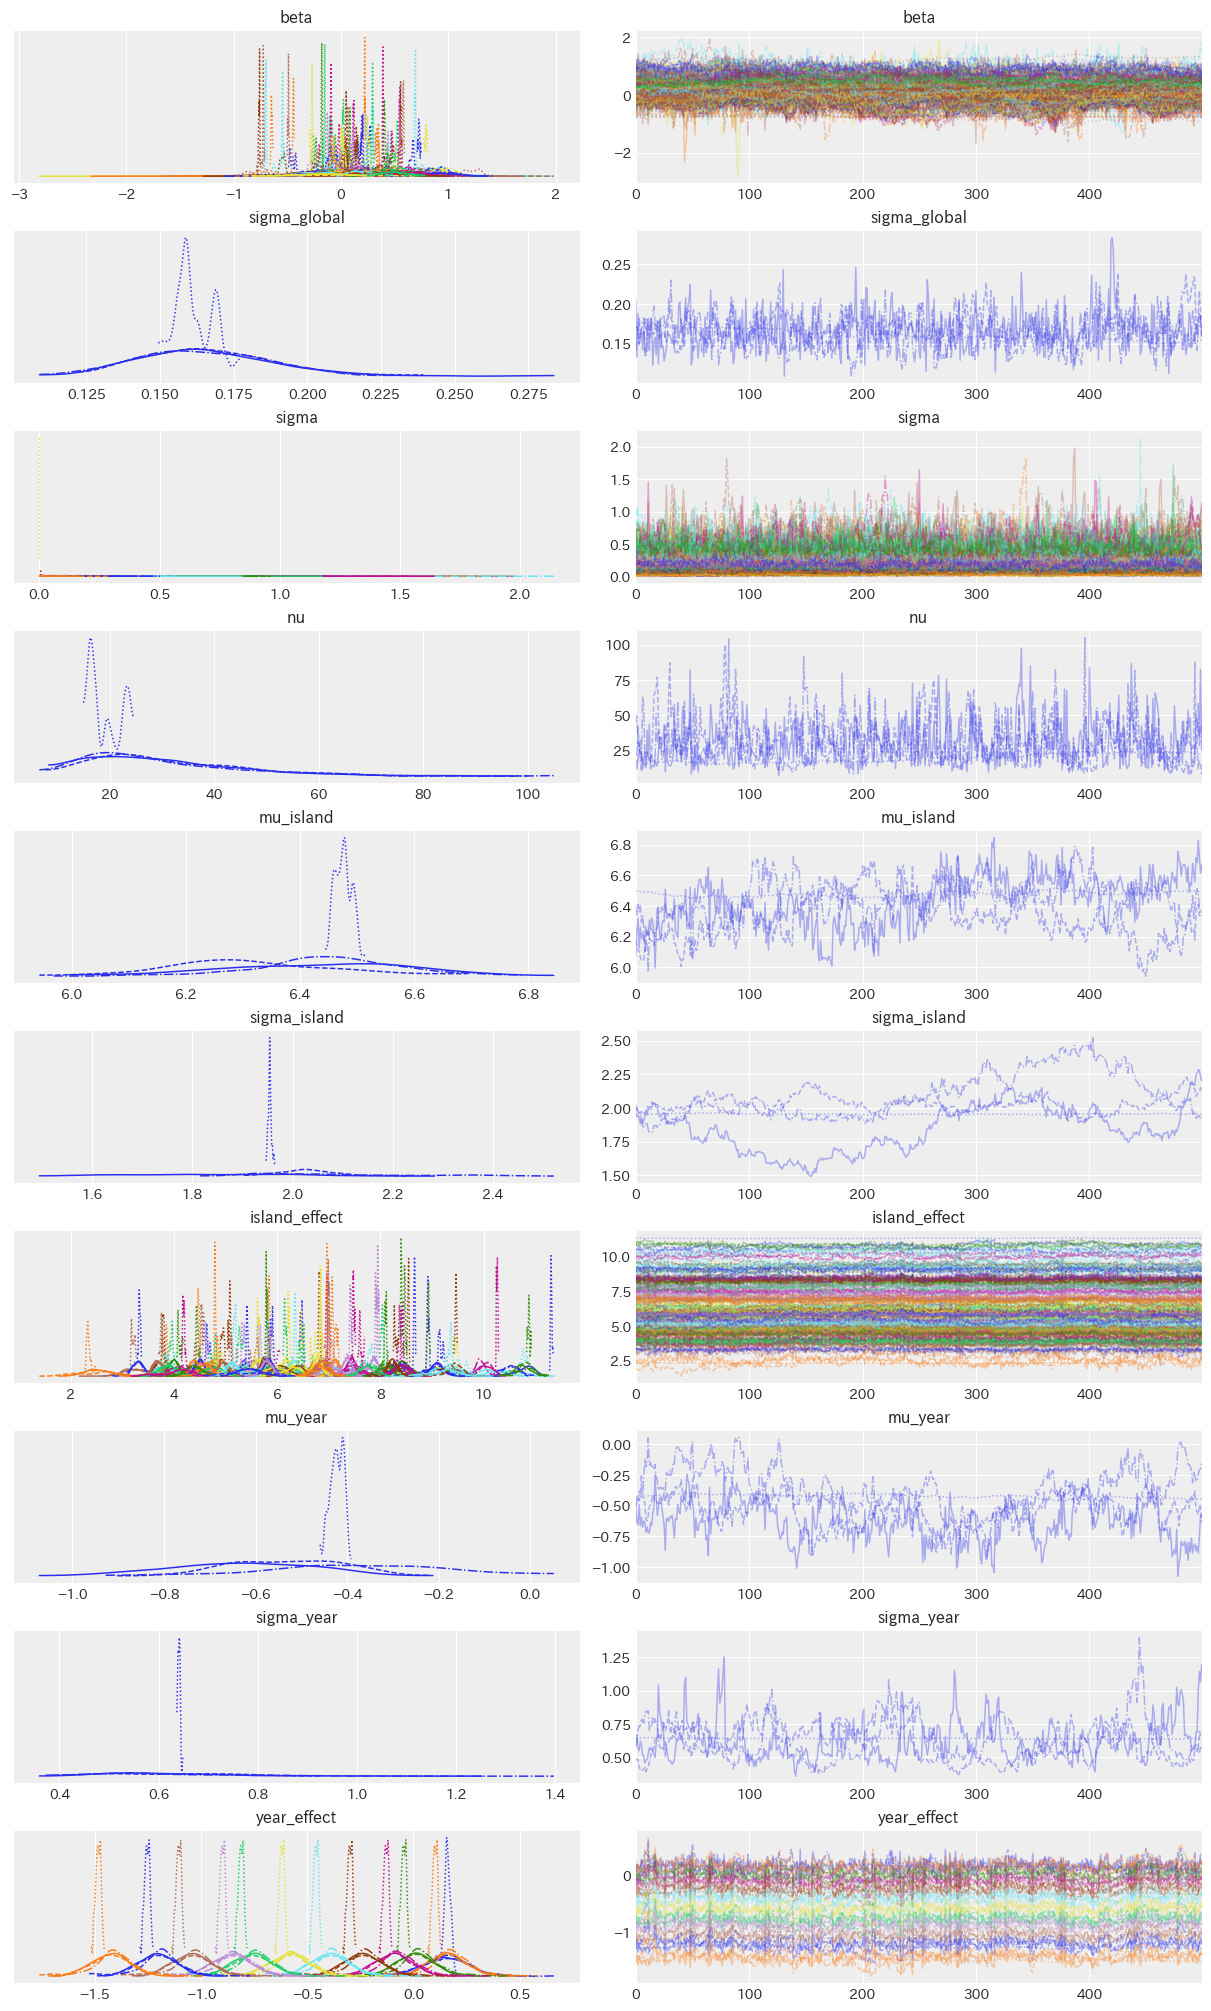

In [280]:
az.plot_trace(
    trace_hetero,
    var_names=[
        'beta', 'sigma_global', 'sigma', 'nu',
        'mu_island', 'sigma_island', 'island_effect',
        'mu_year', 'sigma_year', 'year_effect',
    ]
);

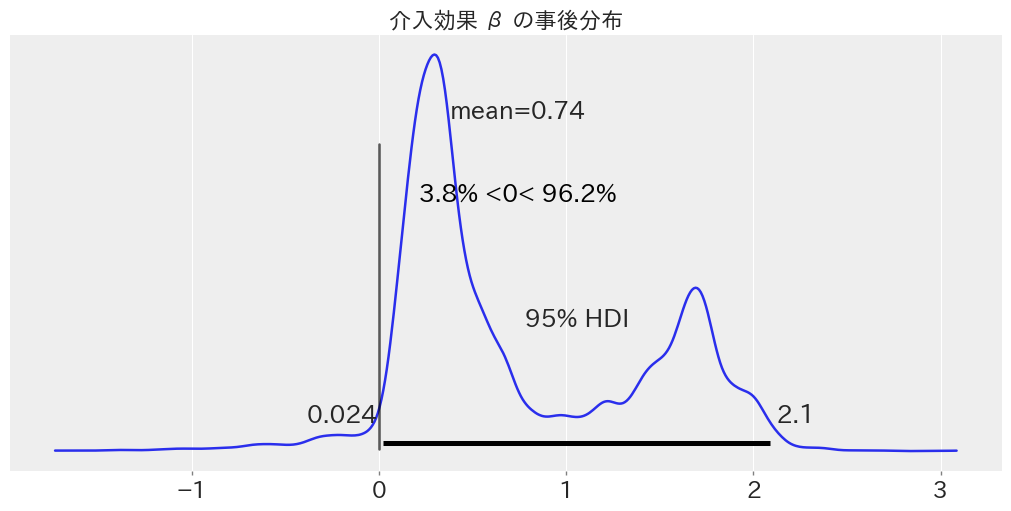

In [59]:
az.plot_posterior(trace_hetero, var_names=['mu_beta'], hdi_prob=0.95, ref_val=0, ref_val_color='k', figsize=(10 ,5));
plt.title('介入効果 β の事後分布');

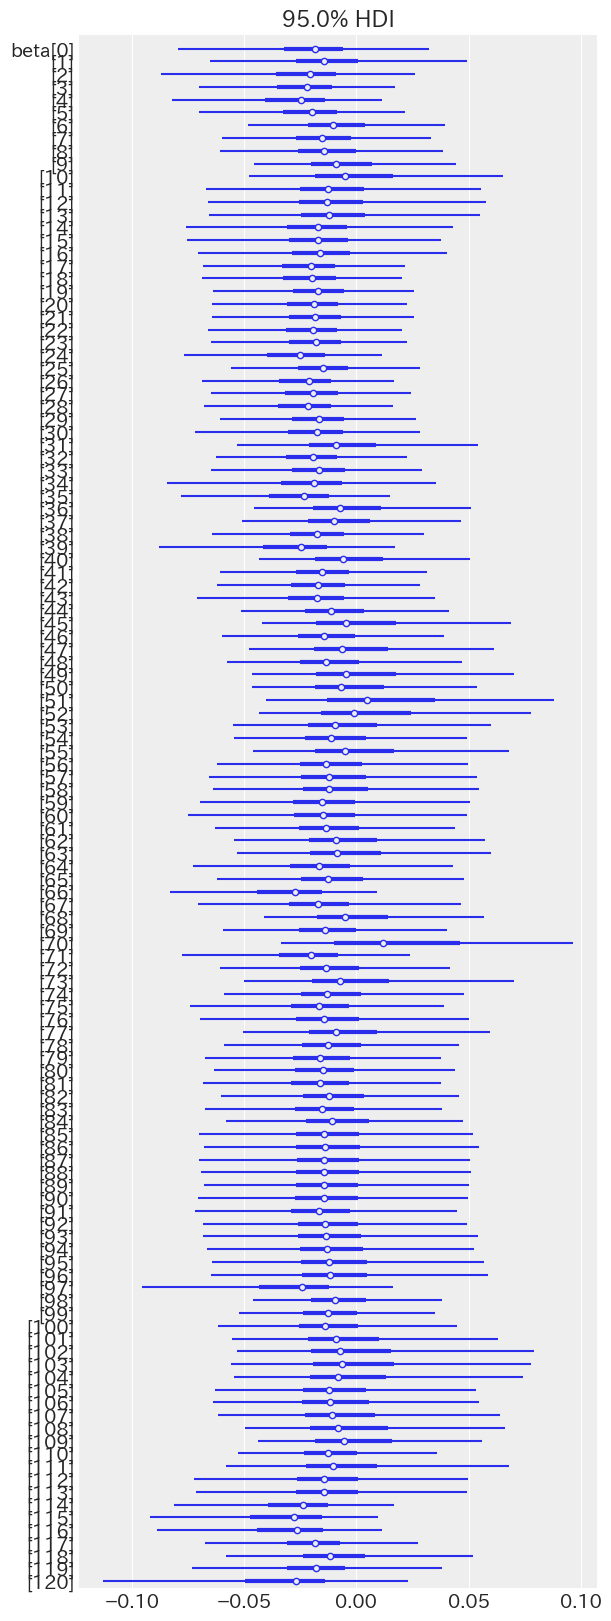

In [16]:
az.plot_forest(trace_dynamic_twfe, var_names=['beta'], combined=True, hdi_prob=0.95);

In [9]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   494.26    42.64
p_waic      103.58        -

There has been a warning during the calculation. Please check the results.

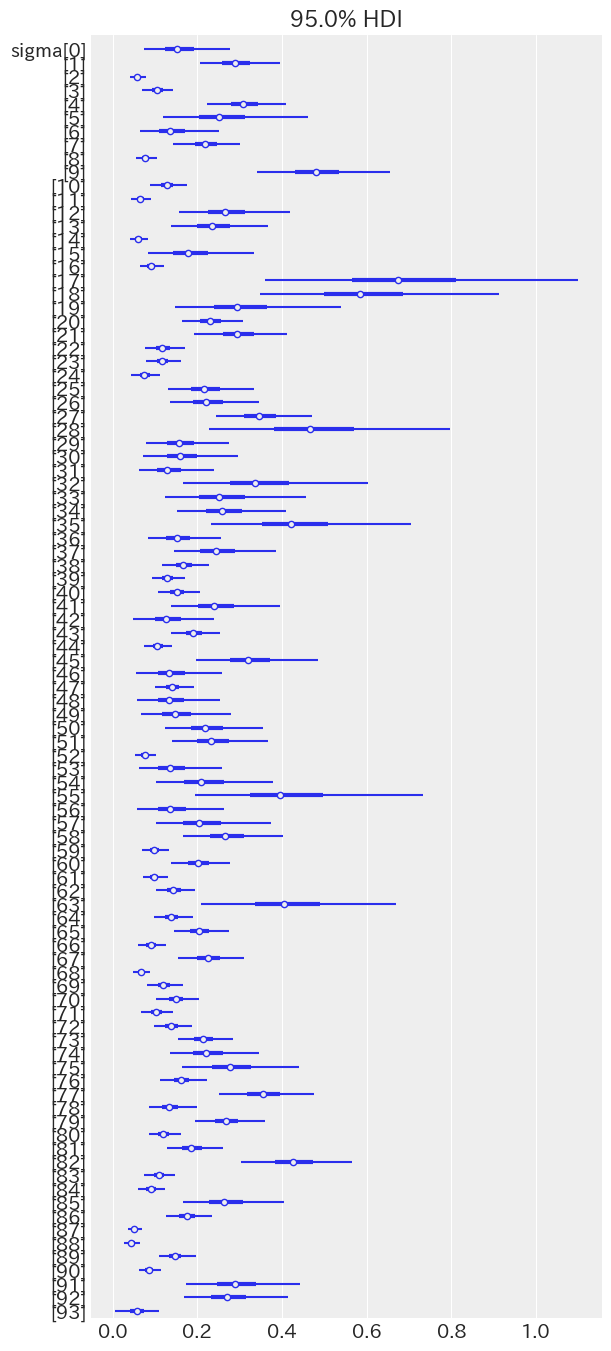

In [75]:
az.plot_forest(trace_dynamic_twfe, var_names=['sigma'], combined=True, hdi_prob=0.95);

## 階層ベイズモデル 均一分散

$$
\begin{aligned}
\log{Y_{it}} = \beta_i \cdot  W_{it} + \epsilon_{it} \\
\epsilon_{it} \sim N(0, \sigma^2)
\end{aligned}
$$

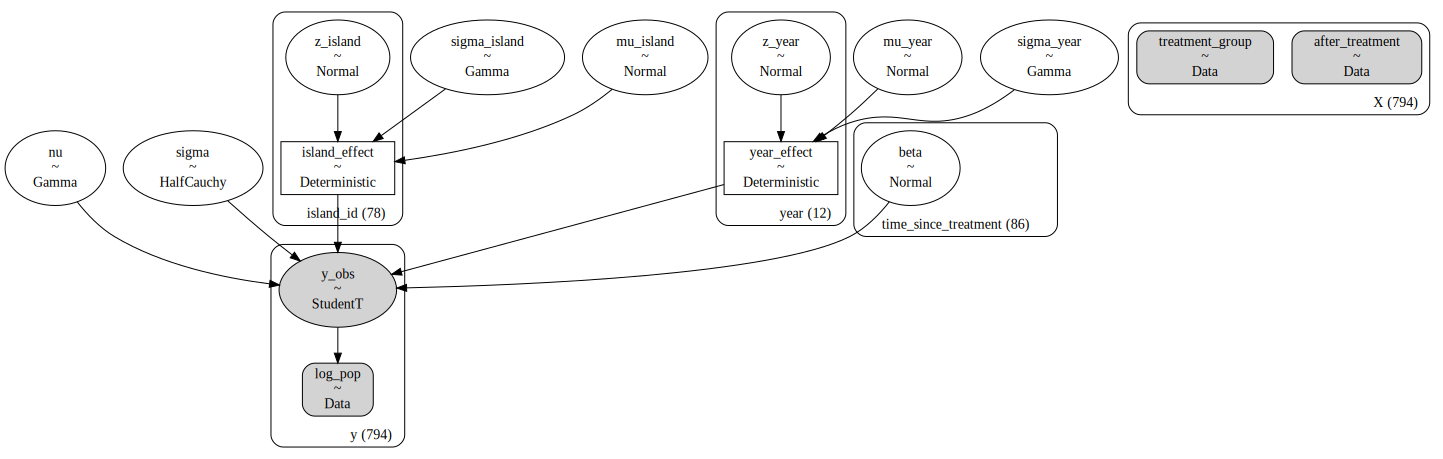

In [5]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[-46.0]', 'C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'time_since_treatment': time_since_treatment_dummies.columns,
}

with pm.Model(coords=COORDS) as model_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect

    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    sigma = pm.HalfCauchy('sigma', beta=1)

    # fixed effect
    # alpha = pm.Normal('alpha', qmu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='time_since_treatment')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(time_since_treatment_dummies, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop, dims='y')

pm.model_to_graphviz(model_homo)

In [6]:
with model_homo:
    trace_homo = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [7]:
az.to_netcdf(trace_homo, './mcmc_sample/dynamic/homo_kokucho_modified_20240110.nc')

'./mcmc_sample/dynamic/homo_kokucho_modified_20240110.nc'

In [8]:
az.summary(trace_homo, var_names=['sigma', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year', 'nu'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
sigma         0.119  0.010     0.100      0.137      0.000    0.000    2588.0   
mu_island     6.470  0.252     5.983      6.962      0.007    0.005    1275.0   
sigma_island  1.942  0.159     1.651      2.267      0.004    0.003    1492.0   
mu_year      -0.748  0.220    -1.179     -0.305      0.004    0.003    3693.0   
sigma_year    0.641  0.162     0.379      0.961      0.003    0.002    3069.0   
nu            1.868  0.226     1.447      2.313      0.004    0.003    3706.0   

              ess_tail  r_hat  
sigma           4142.0   1.00  
mu_island       2520.0   1.01  
sigma_island    2319.0   1.00  
mu_year         4019.0   1.00  
sigma_year      3706.0   1.00  
nu              4508.0   1.00

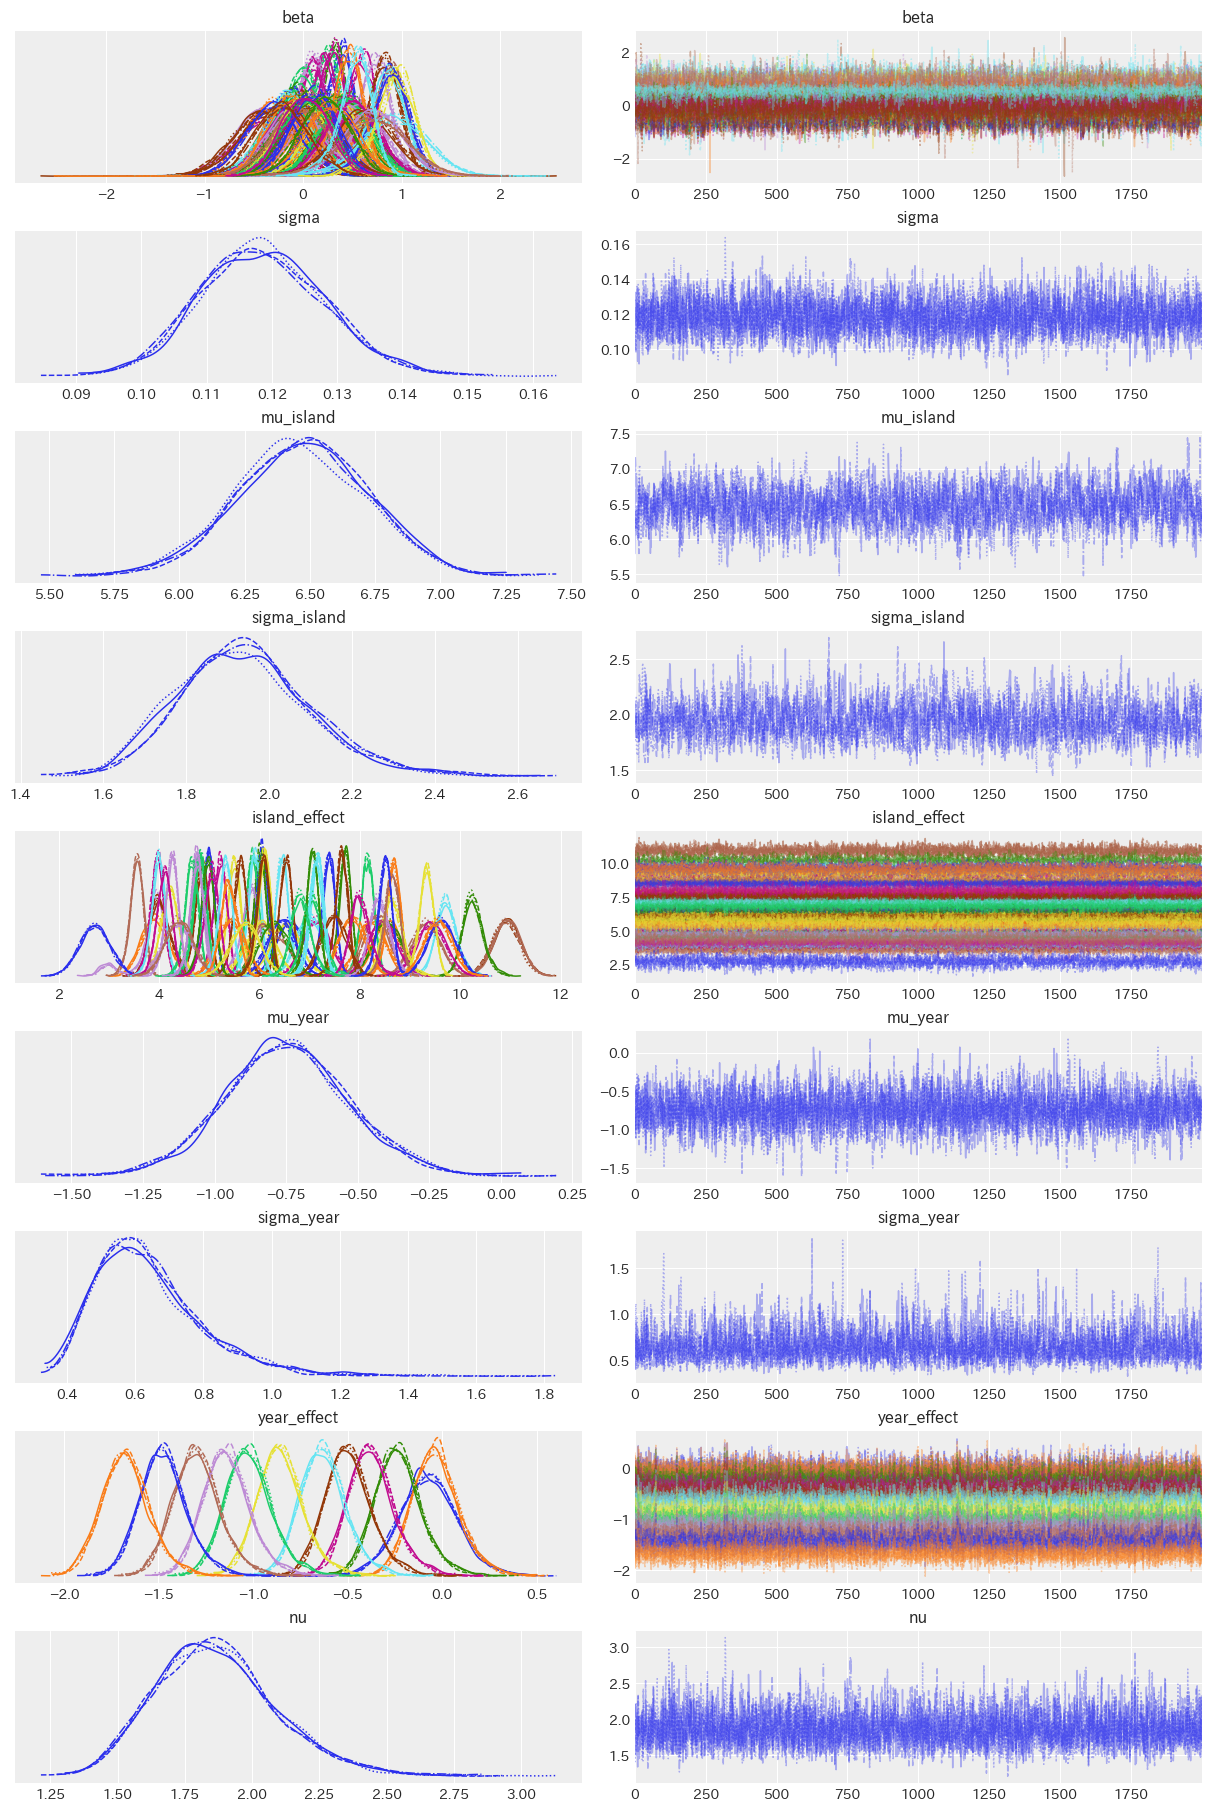

In [10]:
az.plot_trace(
    trace_homo,
    var_names=[
        'beta',
        'sigma',
        'mu_island', 'sigma_island', 'island_effect',
        'mu_year', 'sigma_year', 'year_effect',
        'nu'
    ]
);

In [9]:
with model_homo:
    pm.compute_log_likelihood(trace_homo)

az.waic(trace_homo)

Output()

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 782 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -58.91    32.75
p_waic      252.72        -

There has been a warning during the calculation. Please check the results.

## プロット

In [12]:
def get_beta_df(trace):
    # ランダム効果のサマリーを取得
    beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    # time_since_treatment_df = pd.DataFrame(unique_time_since_treatment, columns=['time_since_treatment_str'])
    # time_since_treatment_df['time_since_treatment'] = time_since_treatment_df['time_since_treatment_str'].apply(extract_number)

    # ランダム効果の値を経過年数と結合
    # ランダム効果の順番は経過年数の昇順ではなく，データに登場した順番になっている．
    # beta_df.reset_index(drop=True, inplace=True)
    # beta_df = pd.concat([beta_df, time_since_treatment_df], axis=1)
    # pattern = r'beta\[(\-?\d+.\d+)\]' # beta[-45.0]
    pattern = r"beta\[C\(time_since_treatment\)\[(-?\d+\.\d+)\]\]"
    extracted = beta_df.index.str.extract(pattern)
    extracted.index = beta_df.index
    beta_df['time_since_treatment'] = extracted[0].astype(float)
    beta_df = beta_df.query('time_since_treatment < 1000').sort_values('time_since_treatment')

    # 新しい列に数値を格納

    return beta_df

class BetaPlotter:
    def __init__(self, beta_df):
        self.beta_df = beta_df

    def plot_effects_over_time(self, title):
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(
            x='time_since_treatment',
            y='mean',
            data=self.beta_df,
            marker='o',
            color='black',
            label='事後期待値',
            ax=ax
        )
        ax.fill_between(
            x=self.beta_df['time_since_treatment'],
            y1=self.beta_df['hdi_97.5%'],
            y2=self.beta_df['hdi_2.5%'],
            color='gray',
            alpha=0.5,
            label='95%信用区間'
        )
        ax.axvline(x=0, color='black', linestyle=':')
        ax.axhline(y=0, color='black', linestyle=':')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('')
        ax.set_title(title)
        ax.legend()
        path = '../../docs/figures/dynamic_twfe/dynamic_twfe_beta_l.png'
        plt.savefig(path, bbox_inches='tight')

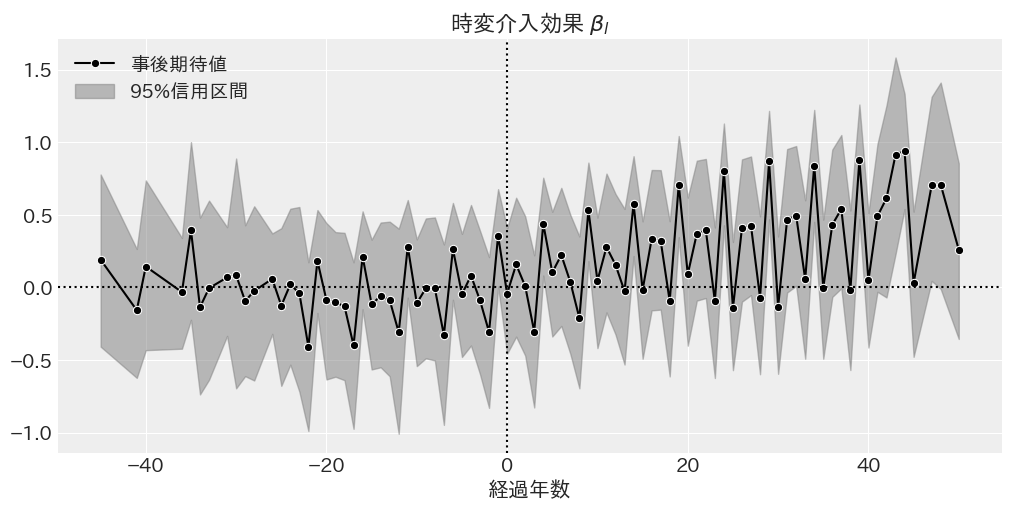

In [13]:
beta_df = get_beta_df(trace_homo)
plotter = BetaPlotter(beta_df)
plotter.plot_effects_over_time('時変介入効果 $β_l$')

In [14]:
beta_df.rename(columns={'hdi_2.5%': 'hdi_lower', 'hdi_97.5%': 'hdi_upper'}, inplace=True)

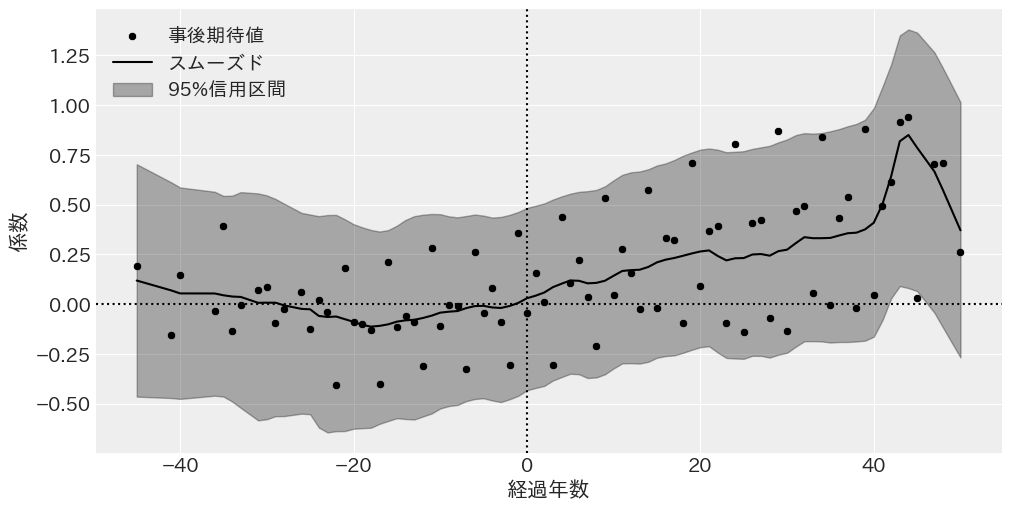

In [40]:
from statsmodels.nonparametric.smoothers_lowess import lowess

smoothed_coef = lowess(beta_df['mean'], beta_df.time_since_treatment, frac=0.1)
smoothed_hdi_lower = lowess(beta_df.hdi_lower, beta_df.time_since_treatment, frac=0.1)
smoothed_hdi_upper = lowess(beta_df.hdi_upper, beta_df.time_since_treatment, frac=0.1)

beta_df['smoothed_coef'] = smoothed_coef[:, 1]
beta_df['smoothed_hdi_lower'] = smoothed_hdi_lower[:, 1]
beta_df['smoothed_hdi_upper'] = smoothed_hdi_upper[:, 1]

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    x='time_since_treatment',
    y='mean',
    data=beta_df,
    color='black',
    label='事後期待値'
)
sns.lineplot(
    x='time_since_treatment',
    y='smoothed_coef',
    data=beta_df,
    ax=ax,
    color='black',
    label='スムーズド'
)
ax.fill_between(
    x='time_since_treatment',
    y1='smoothed_hdi_lower',
    y2='smoothed_hdi_upper',
    data=beta_df,
    alpha=0.3,
    color='black',
    label='95%信用区間'
)
ax.axvline(x=0, color='black', linestyle=':')
ax.axhline(y=0, color='black', linestyle=':')
ax.set_xlabel('経過年数')
ax.set_ylabel('係数')
ax.legend()

In [158]:
with pm.Model() as smoothing:
    # data
    smoothing.add_coord('time', values=beta_df['time_since_treatment'])
    y = pm.Data('y', beta_df['mean'])
    x = pm.Data('x', beta_df['time_since_treatment'])

    # priors
    sigma_zeta = pm.HalfCauchy('sigma_zeta', beta=1)
    sigma_w = pm.HalfCauchy('sigma_w', beta=1)
    sigma_v = pm.HalfCauchy('sigma_v', beta=1)

    # init
    delta_0 = pm.Normal.dist(mu=0, sigma=10)
    mu_0 = pm.Normal.dist(mu=0, sigma=10)

    # trend
    delta = pm.GaussianRandomWalk('delta', sigma=sigma_zeta, init_dist=delta_0, shape=len(beta_df['time_since_treatment'])-1)

    # level
    mu = pm.GaussianRandomWalk('mu', mu=delta, sigma=sigma_w, init_dist=mu_0, dims='time')

    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_v, observed=y, dims='time')

    trace_smoothing = pm.sample(
        draws=4000,
        tune=4000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
        target_accept=.99
    )

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [160]:
az.summary(trace_smoothing, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
delta[0]   -0.003  0.013    -0.032      0.021      0.001    0.001     207.0   
delta[1]   -0.003  0.013    -0.030      0.021      0.001    0.001     200.0   
delta[2]   -0.003  0.012    -0.030      0.019      0.001    0.001     194.0   
delta[3]   -0.003  0.012    -0.028      0.018      0.001    0.001     182.0   
delta[4]   -0.003  0.012    -0.026      0.018      0.001    0.001     170.0   
...           ...    ...       ...        ...        ...      ...       ...   
mu[48.0]    0.555  0.094     0.364      0.728      0.008    0.006     133.0   
mu[50.0]    0.563  0.102     0.356      0.755      0.009    0.006     127.0   
sigma_zeta  0.003  0.003     0.000      0.008      0.000    0.000      47.0   
sigma_w     0.022  0.016     0.000      0.053      0.004    0.003      13.0   
sigma_v     0.268  0.021     0.226      0.309      0.000    0.000    2009.0   

            ess_tail  r_hat  
delta[0]       382.0   1.02  
delta[1]       376.0   1.03  
delta[2]       329.0   1.03  
delta[3]       432.0   1.03  
delta[4]       335.0   1.03  
...              ...    ...  
mu[48.0]      1585.0   1.04  
mu[50.0]      1389.0   1.04  
sigma_zeta      55.0   1.06  
sigma_w         73.0   1.22  
sigma_v       3976.0   1.00  

[174 rows x 9 columns]

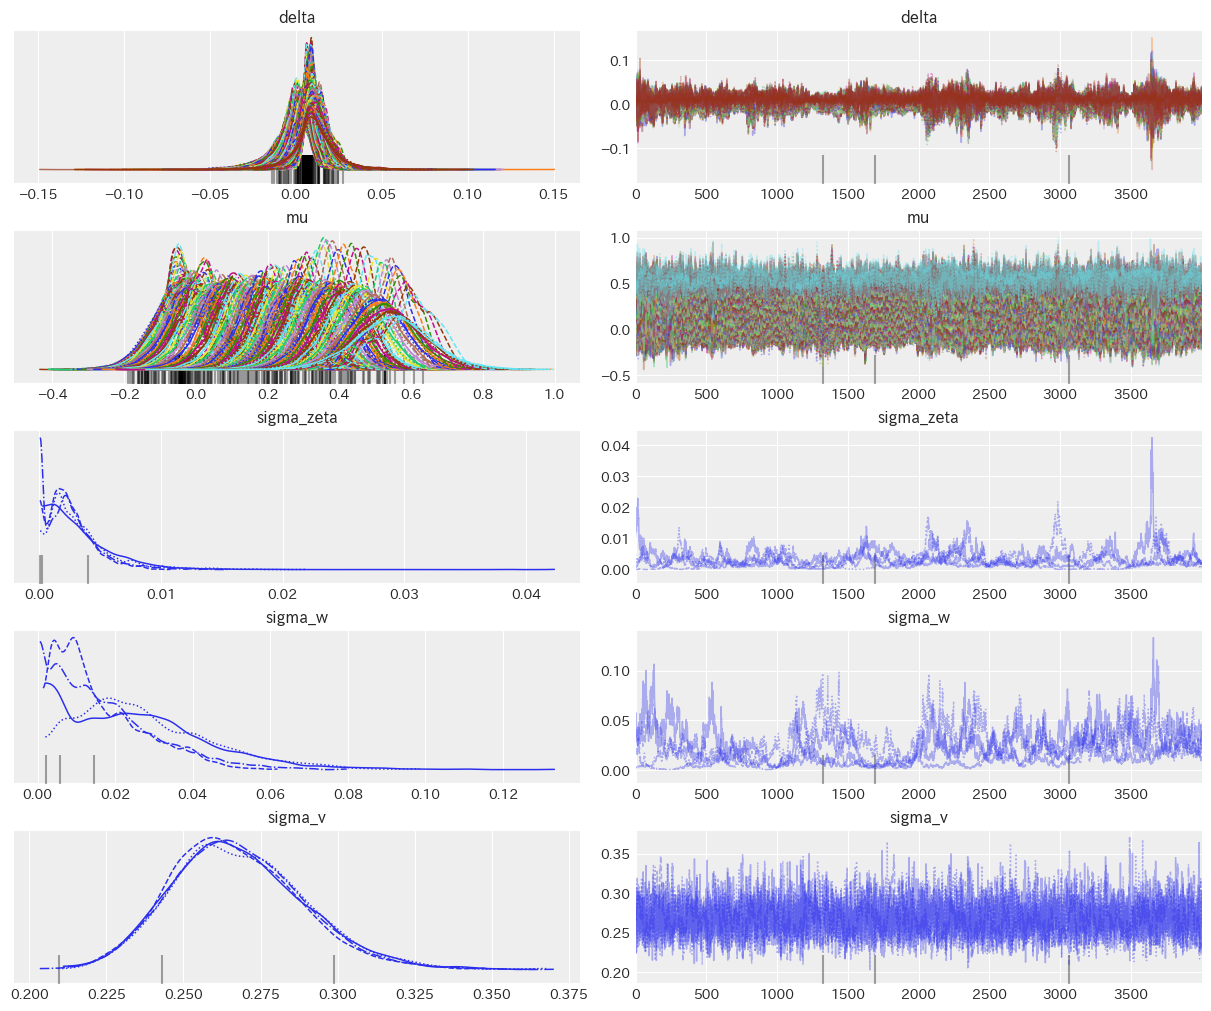

In [159]:
az.plot_trace(trace_smoothing);

In [161]:
with smoothing:
    pm.sample_posterior_predictive(trace_smoothing, extend_inferencedata=True)

Sampling: [y_obs]


Output()

In [170]:
class PosteriorPlotrer:
    def __init__(self, data, idata):
        self.data = data
        self.idata = idata

    def _plot_posterior(self, mean, mu_hdi95, y_hdi95, ylabel, display_obs, legend):
        fig, ax = plt.subplots(figsize=(10, 5))

        if display_obs:
            # 観測値の描画
            ax.scatter(self.data['time_since_treatment'], self.data['mean'], color='black', s=8, label='推定値')

        # 事後平均の描画
        ax.plot(self.data['time_since_treatment'], mean[:len(self.data)], color='black', label='スムージング後の期待値')
        # μの95%HDI区間の描画
        ax.fill_between(
            x=self.data['time_since_treatment'],
            y1=mu_hdi95[:len(self.data), 0],
            y2=mu_hdi95[:len(self.data), 1],
            color='black',
            alpha=0.15,
            label='μ 95%信用区間'
        )

        # yの95%HDI区間の描画
        ax.fill_between(
            x=self.data['time_since_treatment'],
            y1=y_hdi95[:len(self.data), 0],
            y2=y_hdi95[:len(self.data), 1],
            color='black',
            alpha=0.15,
            label='推定値 95%信用区間'
        )

        # 修飾
        ax.set(xlabel='経過年数', ylabel=ylabel)
        ax.axvline(x=0, color='black', linestyle=':')
        ax.axhline(y=0, color='black', linestyle=':')
        ax.grid(lw=0.3)
        if legend:
            ax.legend()
        plt.show()

    def plot_lambda_posterior(self):
        tmp = self.idata.posterior
        mean = tmp.lambda_.stack(sample=('chain', 'draw')).mean(axis=1).data
        hdi95 = az.hdi(tmp, hdi_prob=0.95).lambda_.data

        self._plot_posterior(mean, hdi95, 'λ EAP', display_obs=True, legend=True)

    ### muの事後分布の平均値, 95%HDI区間の描画関数の定義
    def plot_mu_posterior(self):

        ## 事後平均・95%HDIの算出
        tmp = self.idata.posterior
        mean = tmp.mu.stack(sample=('chain', 'draw')).mean(axis=1).data
        mu_hdi95 = az.hdi(tmp, hdi_prob=0.95).mu.data
        tmp = self.idata.posterior_predictive
        mean = tmp.y_obs.stack(sample=('chain', 'draw')).mean(axis=1).data
        y_hdi95 = az.hdi(tmp, hdi_prob=0.95).y_obs.data

        self._plot_posterior(mean, mu_hdi95, y_hdi95, 'μ EAP', display_obs=True, legend=True)


    def plot_season_posterior(self):
        tmp = self.idata.posterior
        mean = tmp.gamma.stack(sample=('chain', 'draw')).mean(axis=1).data
        hdi95 = az.hdi(tmp, hdi_prob=0.95).gamma.data

        self._plot_posterior(mean, hdi95, 'γ EAP', display_obs=False, legend=False)

    def plot_all_posterior(self):
        self.plot_lambda_posterior()
        self.plot_mu_posterior()
        self.plot_season_posterior()

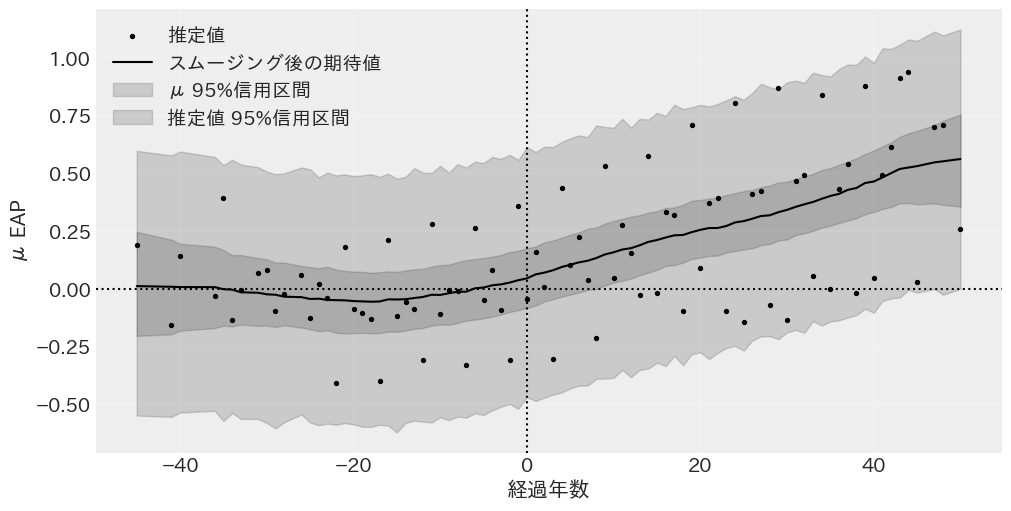

In [171]:
plotter = PosteriorPlotrer(beta_df, trace_smoothing)
plotter.plot_mu_posterior()